In [1]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Point
import json


In [2]:
# Charger les données depuis le fichier CSV
data = pd.read_csv("glassdoor_jobs_dataset.csv")

# Afficher un aperçu des données
data.head()

,Titre,Entreprise,Localisation,Salaire,Contrat,Note_entreprise
0,Formation de reconversion ingénieur en informa...,Credit Mutuel,Strasbourg,€36K - €40K(Employer est.),CDI,3.9
1,Ingénieur Junior H/F,Cloud Factory Business Services,Nanterre,€35K - €40K(Employer est.),CDI,Non spécifié
2,Ingénieur en système d'information,Avenir Business Ressource,Télétravail,€35K(Employer est.),CDI,Non spécifié
3,Ingénieur en Automatisme/Informatique Industri...,Framatome,Romans-sur-Isère,€40K - €55K(Employer est.),CDI,4.0
4,Ingénieur·e en informatique industrielle,Attineos,Évreux,€32K - €36K(Employer est.),CDI,4.3


In [3]:
## Information sur les données
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Titre            819 non-null    object
 1   Entreprise       819 non-null    object
 2   Localisation     819 non-null    object
 3   Salaire          819 non-null    object
 4   Contrat          819 non-null    object
 5   Note_entreprise  819 non-null    object
dtypes: object(6)
memory usage: 38.5+ KB
None


## TRAITEMENT DES DONNEES

In [6]:
# Vérifier les valeurs manquantes
print(data.isna().sum())

Titre              0
Entreprise         0
Localisation       0
Salaire            0
Contrat            0
Note_entreprise    0
dtype: int64


In [7]:
# suppression des doublons:
data.drop_duplicates(inplace=True)

In [8]:
# Fonction pour gérer les salaires

def process_salaire(salaire):
    if salaire == "Non spécifié" or pd.isna(salaire):
        return None, None, None  # salaire_min, salaire_max, salaire_moyen
    
    # Supprimer les parties inutiles (comme "(Employer est.)")
    salaire_cleaned = re.sub(r'\(.*?\)', '', salaire).replace('€', '').replace('K', '000')
    
    # Extraire les montants numériques
    match = re.findall(r'(\d+)', salaire_cleaned)
    if len(match) == 2:  # Plage de salaire (exemple : "36000 - 40000")
        salaire_min = int(match[0])
        salaire_max = int(match[1])
    elif len(match) == 1:  # Salaire unique (exemple : "35000")
        salaire_min = salaire_max = int(match[0])
    else:  # Si aucune donnée valide
        return None, None, None
    
    # Calcul du salaire moyen
    salaire_moyen = (salaire_min + salaire_max) // 2
    
    return salaire_min, salaire_max, salaire_moyen


In [9]:
# Appliquer la fonction à la colonne Salaire

# Appliquer la fonction sur la colonne 'Salaire'
data[['Salaire_Min', 'Salaire_Max', 'Salaire_Moyen']] = data['Salaire'].apply(
    lambda x: pd.Series(process_salaire(x))
)

In [10]:
# Afficher les premières lignes pour vérifier le résultat

data.head()

,Titre,Entreprise,Localisation,Salaire,Contrat,Note_entreprise,Salaire_Min,Salaire_Max,Salaire_Moyen
0,Formation de reconversion ingénieur en informa...,Credit Mutuel,Strasbourg,€36K - €40K(Employer est.),CDI,3.9,36000.0,40000.0,38000.0
1,Ingénieur Junior H/F,Cloud Factory Business Services,Nanterre,€35K - €40K(Employer est.),CDI,Non spécifié,35000.0,40000.0,37500.0
2,Ingénieur en système d'information,Avenir Business Ressource,Télétravail,€35K(Employer est.),CDI,Non spécifié,35000.0,35000.0,35000.0
3,Ingénieur en Automatisme/Informatique Industri...,Framatome,Romans-sur-Isère,€40K - €55K(Employer est.),CDI,4.0,40000.0,55000.0,47500.0
4,Ingénieur·e en informatique industrielle,Attineos,Évreux,€32K - €36K(Employer est.),CDI,4.3,32000.0,36000.0,34000.0


## ANALYSES

### 1. Secteurs et compétences clés
Nous ferons ressortir ceci à travers un nuage de mots

In [11]:
# Concaténer tous les titres en une seule chaîne de texte
text = " ".join(data['Titre'].dropna().tolist())

# Nettoyer les titres pour retirer les termes spécifiques comme "H/F"
text = re.sub(r'\b(H/F|H\.F|H F|F/H)\b', '', text, flags=re.IGNORECASE)
text = re.sub(r'\b(ingénieur|Ingénieur)\b', 'ingénieur', text, flags=re.IGNORECASE)

# Ajouter des mots à exclure
stopwords = set(STOPWORDS)
stopwords.update(["H", "F", "H/F", "de", "en", "pour", "et", "le", "la", "d'un", "d'une", "des", "sur", "avec", "du", "dans", "poste", "d", "e", "x", "X", "ou", "c"])


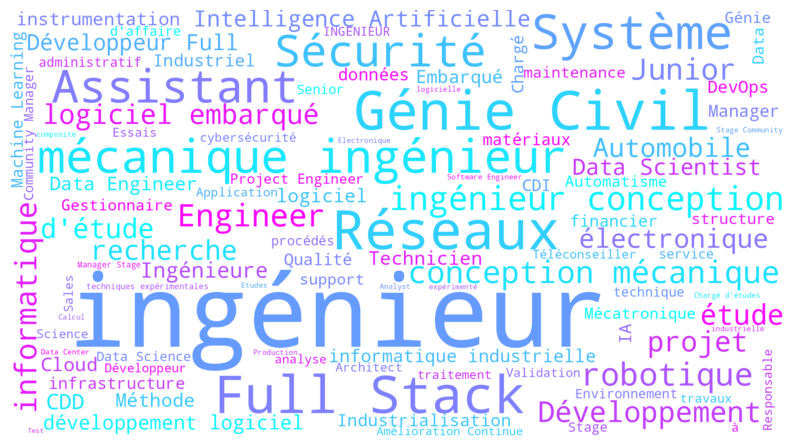

In [11]:
# Créer un nuage de mots
wordcloud = WordCloud(
    width=2000,
    height=1100,
    background_color="white",
    stopwords=stopwords,
    max_words=100,
    colormap="cool"
).generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### 2. Répartition du type de contrat

In [12]:
contract_counts = data['Contrat'].value_counts()
contract_data = contract_counts.reset_index()
contract_data.columns = ["Type de Contrat", "Nombre"]

fig = px.pie(
    contract_data,
    values="Nombre",
    names="Type de Contrat",
    title="Répartition des offres par type de contrat",
    color_discrete_sequence=["#ff7f0e", "#1f77b4"]
)

# Personnalisation
fig.update_traces(
    textinfo="percent+label",
    pull=[0.1 if i == 0 else 0 for i in range(len(contract_data))] 
)

fig.update_layout(
    title=dict(
        text="Répartition des offres par type de contrat",
        x=0.5,  # Centre le titre
        font=dict(size=24)
    ),
    showlegend=False, 
    width=600,
    height=400 
)

fig.show()

### 3. Entreprises qui offrent plus d'emplois

In [13]:
## Classement des entreprises en fonction du nombre d'offre
data['Entreprise'].value_counts()

Entreprise
CNRS              35
Safran            34
CEA               19
Inria             14
Inserm            11
                  ..
POLE DIRECTION     1
AMUE               1
Espritek           1
CKSQUARE           1
Credit Mutuel      1
Name: count, Length: 444, dtype: int64

### 4. Entreprises les mieux notées

In [14]:
# Filtrer les entreprises ayant une note
data_filtered = data[data["Note_entreprise"] != "Non spécifié"].copy()

# Convertir la colonne "Note" en type float
data_filtered["Note_entreprise"] = pd.to_numeric(data_filtered["Note_entreprise"], errors="coerce")

# Grouper par entreprise et calculer la note moyenne si une entreprise apparaît plusieurs fois
ranked_companies = (
    data_filtered.groupby("Entreprise")["Note_entreprise"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

In [15]:
ranked_companies.head(10)

,Entreprise,Note_entreprise
0,SEE YOU SUN,5.0
1,Founders Hub France,5.0
2,Chanel,5.0
3,JUNGHANS T2M SAS,5.0
4,Rtone,5.0
5,Lenstra,5.0
6,Centre hospitalier Joseph Imbert,5.0
7,MYTTRA,5.0
8,Aketys,5.0
9,ENVEA,5.0


### 5. Analyse du salaire moyen proposé (tout secteur confondus)

In [16]:
## Stats sommaire

data['Salaire_Moyen'].describe()

count      345.000000
mean     31103.344928
std      20299.365599
min          1.000000
25%       3000.000000
50%      38000.000000
75%      45000.000000
max      80000.000000
Name: Salaire_Moyen, dtype: float64

### 6. Entreprises / domaines qui payent le mieux

In [17]:
# Trier les données par salaire moyen décroissant et sélectionner les 10 premières
top_10_salaries = data.sort_values(by='Salaire_Moyen', ascending=False).head(10)

# Afficher les informations importantes pour ces postes
top_10_info = top_10_salaries[['Titre', 'Entreprise', 'Salaire_Moyen', 'Contrat']]

# Visualisation sous forme de tableau avec Plotly

fig = go.Figure(data=[go.Table(
    header=dict(values=["Titre", "Entreprise", "Salaire moyen (€)", "Contrat"],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        top_10_info['Titre'],
        top_10_info['Entreprise'],
        top_10_info['Salaire_Moyen'],
        top_10_info['Contrat']],
        fill_color='lavender',
        align='left')
)])
fig.update_layout(title="Top 10 des salaires moyens proposés")
fig.show()


In [18]:
top_10_info

,Titre,Entreprise,Salaire_Moyen,Contrat
5,"Ingénieur en virtualisation, stockage et sauve...",Cost Solutions,80000.0,CDI
131,Regional Sales Manager - Professional Haircare,evo,80000.0,CDI
138,Regional Sales Manager - Professional Haircare,evo,80000.0,CDD
14,Ingénieur virtualisation stockage H/F,Groum K,73000.0,CDI
576,Business Developer H/F - Ingénieur d'affaires,AFTERDATA,70000.0,CDI
181,Architecte cloud,Messilat,66500.0,CDD
719,Ingénieur Full Stack Java - (H/F/X),Arolla,65000.0,CDI
772,Ingénieur Systèmes et Réseaux H/F,INFORMATIS,65000.0,CDI
661,Ingénieur logiciel .NET (F/H/X),AROLLA,62500.0,CDI
797,Ingénieur système et réseau,SECURINFOR,62500.0,CDD


### 7. Corrélation entre salaire moyen et note de l'entreprise

In [19]:
# Remplacer les valeurs 'Non spécifié' par NaN
data['Salaire_moyen_cor'] = data['Salaire_Moyen'].replace('Non spécifié', np.nan).astype(float)
data['Note_cor'] = data['Note_entreprise'].replace('Non spécifié', np.nan).astype(float)

# Filtrer les lignes où Salaire_moyen et Note sont non nulles
filtered_data = data.dropna(subset=['Salaire_moyen_cor', 'Note_entreprise'])

# Calculer la corrélation
correlation = filtered_data[['Salaire_moyen_cor', 'Note_cor']].corr().iloc[0, 1]
print(f"Corrélation entre le salaire moyen et la note de l'entreprise : {correlation:.2f}")

Corrélation entre le salaire moyen et la note de l'entreprise : -0.07


### 8. Analyse de la répartition géographique des emplois

In [12]:
# Proportion des emplois en télétravail
teletravail_count = data['Localisation'].str.contains('Télétravail', case=False, na=False).sum()
proportion_teletravail = teletravail_count / len(data) * 100
print(f"Proportion des emplois en télétravail : {proportion_teletravail:.2f}%")

Proportion des emplois en télétravail : 1.92%


In [14]:
data['Localisation']

0             Strasbourg
1               Nanterre
2            Télétravail
3       Romans-sur-Isère
4                 Évreux
             ...        
814               France
815                Paris
816                Paris
817    Villers-Cotterêts
818                Paris
Name: Localisation, Length: 728, dtype: object